# Global Forecasting System - Meteorological forecast

In [1]:
from datetime import datetime
import xarray
import numpy as np
from mikeio.dfs_util import type_list, unit_list
import pandas as pd

Let's try to download todays forecast from the OpenDAP server.

In [2]:
now = datetime.now()

forecast = datetime(now.year,now.month,now.day)

In [3]:
dtstr = forecast.strftime("%Y%m%d")
hour = "00" # valid options are 00,06,12,18
url = f"https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs{dtstr}/gfs_0p25_{hour}z"
ds = xarray.open_dataset(url)

In [4]:
ds.time.values[0],ds.time.values[-1]

(numpy.datetime64('2020-02-07T00:00:00.000000000'),
 numpy.datetime64('2020-02-17T00:00:00.000000000'))

In [5]:
(ds.time.values[-1]- ds.time.values[0]).astype('timedelta64[D]')

numpy.timedelta64(10,'D')

The forecast contains data for the coming 10 days.

Running a Mike 21 HD model, needs at least three variables of meteorlogical forcing
* Mean Sea Level Pressure
* U 10m
* V 10m

In [6]:
ds.msletmsl

<xarray.DataArray 'msletmsl' (time: 81, lat: 721, lon: 1440)>
[84097440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-02-07 2020-02-07T03:00:00 ... 2020-02-17
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  ** mean sea level mslp (eta model reduction) [pa]

In [7]:
ds.ugrd10m

<xarray.DataArray 'ugrd10m' (time: 81, lat: 721, lon: 1440)>
[84097440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-02-07 2020-02-07T03:00:00 ... 2020-02-17
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  ** 10 m above ground u-component of wind [m/s]

In [8]:
ds.vgrd10m

<xarray.DataArray 'vgrd10m' (time: 81, lat: 721, lon: 1440)>
[84097440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-02-07 2020-02-07T03:00:00 ... 2020-02-17
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  ** 10 m above ground v-component of wind [m/s]

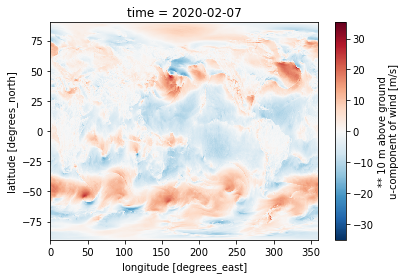

In [9]:
ds.ugrd10m[0].plot()

## Extract a sub-area for e.g. the Adriatic Sea

In [10]:
ds = ds.sel(lon=slice(10,25), lat=slice(30,50))

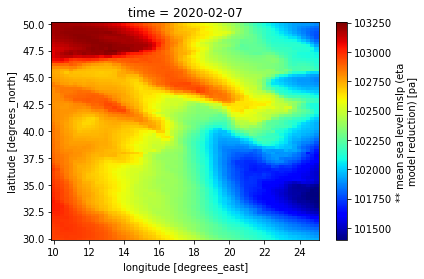

In [52]:
ds.msletmsl[0].plot(cmap='jet')

## Convert to dfs2

In [44]:
lat = ds.lat.values
lon = ds.lon.values


nx = len(lon)
ny = len(lat)

x0 = lon[0]
y0 = lat[0]


dx = np.round((lon[-1] - lon[0]) / nx,2)
dy = np.round((lat[-1] - lat[0]) / ny,2)

x0, y0, nx, ny, dx, dy

(10.0, 30.0, 61, 81, 0.25, 0.25)

## Time

In [12]:
t = ds.time.values
start_time = pd.to_datetime(t).to_pydatetime()[0]

## Variable types

In [15]:
type_list("Air pressure")

{100409: 'Air Pressure'}

In [17]:
unit_list(100409)

{6101: 'hectopascal', 6108: 'millibar'}

In [16]:
type_list("Wind")

{100002: 'Wind Velocity',
 100003: 'Wind Direction',
 100105: 'Wind friction factor',
 100274: 'Wind speed',
 100276: 'Depth of Wind',
 110021: 'Wind friction speed'}

In [19]:
unit_list(100002)

{2000: 'meter/sec',
 2002: 'feet/sec',
 2020: 'miles/hour',
 2021: 'km/hour',
 2019: 'knot'}

This example extracts the first 10 timesteps. Note that in order to download the entire forecast, you have to handle the non-equidistant time axis.

In [48]:
mslp = ds.msletmsl[0:10].values / 100 # conversion from Pa to hPa
u = ds.ugrd10m[0:10].values
v = ds.vgrd10m[0:10].values

Flip data upside down

In [49]:
mslp = mslp[:,::-1,:]
u = u[:,::-1,:]
v = v[:,::-1,:]

In [51]:
from mikeio.dfs2 import dfs2

d = []
d.append(mslp)
d.append(u)
d.append(v)

dfsfilename = f"gfs_{dtstr}_{hour}.dfs2"

coordinate = ['LONG/LAT', x0, y0, 0]

dfs = dfs2()
dfs.create(filename=dfsfilename,
           data=d,
           start_time = start_time,
           dt=3600,
           coordinate=coordinate, length_x=dx, length_y=dy,
           names=["Mean Sea Level Pressure","Wind U","Wind V"], 
           variable_type=[100409,100002,100002], unit=[6101,2000,2000]
)

![GFS in dfs2 format](gfs.png)